## Predictive Coding Neural Network for MNIST Classification


### Environment Setup and Imports
- Import core libraries for deep learning, data handling, and visualization.
- Set device to GPU if available.
- Enable inline plotting for Jupyter.

In [104]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# to display matplotlib plots inline (directly below the cell)
%matplotlib inline

Using device: cpu


### Data Preparation and Loading
- Define MNIST image transformations and normalization.
- Download and split MNIST into training, validation, and test sets.
- Create DataLoader objects for efficient batching.
- Print dataset and batch statistics.

In [105]:
transform = transforms.Compose([
    transforms.ToTensor(),                   
    transforms.Normalize((0.1307,), (0.3081,))  
])

# get the MNIST dataset for training
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

full_test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

val_size = 5000
test_size = len(full_test_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(full_test_dataset, [val_size, test_size])


# create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in validation: {len(validation_loader)}")
print(f"Number of batches in testing: {len(test_loader)}")

Training dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000
Number of batches in training: 1875
Number of batches in validation: 157
Number of batches in testing: 157


### visualize a batch of training images to understand our input data, vertify the data loaded correctly and see examples.

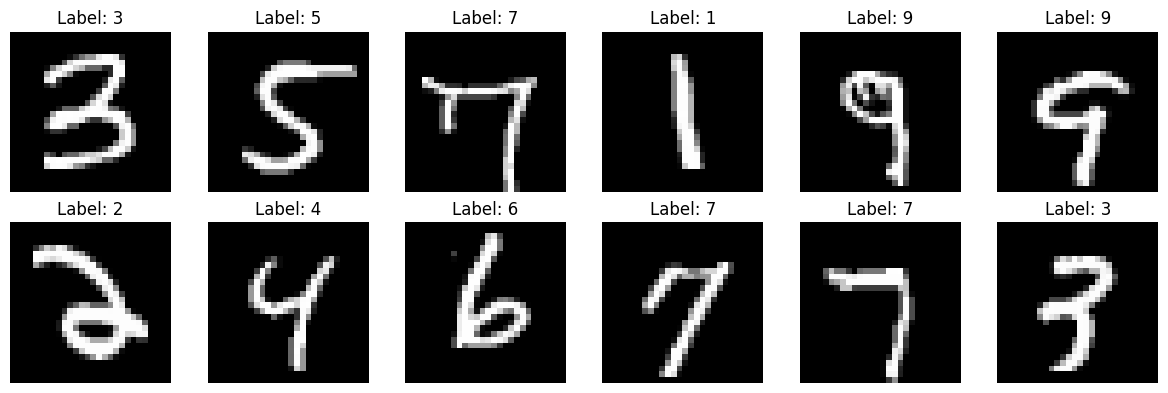

In [106]:
# get a batch of training data
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    # remove normalization
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Predictive Coding Model Definition
- Define a neural network with feedforward and lateral connections.
- Initialize weights and mask lateral self-connections.
- Implement a custom forward method for predictive coding.
- Instantiate and print the model.

In [118]:
class PCMNISTNet(nn.Module):
    def __init__(self):
        super(PCMNISTNet, self).__init__()
        self.W1 = nn.Linear(28*28, 256, bias=True)
        self.W2 = nn.Linear(256, 128, bias=True)
        self.W3 = nn.Linear(128, 64, bias=True)
        self.W4 = nn.Linear(64, 10, bias=True)
        # lateral connections for hidden layers 2 and 3
        self.L2 = nn.Linear(128, 128, bias=True)
        self.L3 = nn.Linear(64, 64, bias=True)
        
        for layer in [self.L2, self.L3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            mask = ~torch.eye(layer.weight.shape[0], dtype=torch.bool)
            layer.weight.data *= mask # to avoid self connection
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
                
        self.act = torch.relu

    def predict(self, x, lateral_strength=0.1):
        # forward pass to initialize latent states
        z0 = x.view(x.size(0), -1)
        z1 = self.act(self.W1(z0))
        z2_ff = self.act(self.W2(z1))
        lat2 = self.act(self.L2(z2_ff))
        z2 = z2_ff + lateral_strength * lat2
        z3_ff = self.act(self.W3(z2))
        lat3 = self.act(self.L3(z3_ff))
        z3 = z3_ff + lateral_strength * lat3
        z4 = self.W4(z3) # we want raw outputs here so no activation
        return [z0, z1, z2, z3, z4]

# Instantiate model
model = PCMNISTNet().to(device)
print(model)

PCMNISTNet(
  (W1): Linear(in_features=784, out_features=256, bias=True)
  (W2): Linear(in_features=256, out_features=128, bias=True)
  (W3): Linear(in_features=128, out_features=64, bias=True)
  (W4): Linear(in_features=64, out_features=10, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=64, out_features=64, bias=True)
)


### JIT-optimized parallel prediction wrapper
- Implement parallel prediction using TorchScript's fork/wait mechanism
- Create wrapper class to split batch into chunks for concurrent processing

In [119]:
# trace the predict method of the model
example_input = torch.randn(1, 1, 28, 28, device=device)
traced_model = torch.jit.trace_module(model, {"predict": (example_input,)})
print("Traced model (ScriptModule) created for predict().")

# define a wrapper that runs predict in parallel
class ParallelPredictWrapper(torch.nn.Module):
    def __init__(self, traced_mod):
        super().__init__()
        self.traced_mod = traced_mod

    @torch.jit.export
    def parallel_predict(self, x: torch.Tensor, chunks: int = 4) -> List[torch.Tensor]:
        B = x.size(0)
        actual_chunks = min(chunks, B)
        parts = x.split((B + actual_chunks - 1) // actual_chunks)
        futures: List[torch.jit.Future[List[torch.Tensor]]] = []
        
        for p in parts:
            fut = torch.jit.fork(self.traced_mod.predict, p)
            futures.append(fut)

        results: List[List[torch.Tensor]] = []
        for fut in futures:
            results.append(torch.jit.wait(fut))

        num_layers = len(results[0])
        concatenated: List[torch.Tensor] = []
        for layer_idx in range(num_layers):
            concatenated.append(torch.cat([res[layer_idx] for res in results], dim=0))
        return concatenated

# script the wrapper
wrapper = ParallelPredictWrapper(traced_model).to(device)
scripted_wrapper = torch.jit.script(wrapper)
print("Scripted wrapper with parallel_predict created successfully.")

Traced model (ScriptModule) created for predict().
Scripted wrapper with parallel_predict created successfully.


### Predictive Coding Training and Evaluation Functions
- Implement predictive coding batch training with latent state updates.
- Update weights and biases using predictive coding rules.
- Provide an evaluation function for loss and accuracy.


In [120]:
inference_steps = 10
alpha = 0.05 # latent state learning rate
eta = 0.01 # weight learning rate
lateral_strength = 0.1
eps = 1e-8 # small epsilon for numerical stability

@torch.no_grad()
def pc_train_batch_parallel(model, x, y_onehot):
    # Initial forward pass
    zs = model.predict(x, lateral_strength=lateral_strength)
    Ws = [model.W1, model.W2, model.W3, model.W4]
    Ls = [model.L2, model.L3]
    L = len(Ws)
    batch_size = x.size(0)
    zs[L] = y_onehot  # clamp output with true labels
    
    # store previous values for parallel updates
    prev_zs = [z.clone() for z in zs]
    
    for _ in range(inference_steps):
        # calculate all errors in parallel
        errors = [None] * (L + 1)
        for l in range(1, L + 1):
            if l < L:
                ff_pred = model.act(Ws[l-1](prev_zs[l-1]))
                if l == 2:
                    lat_pred = model.act(Ls[0](prev_zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                elif l == 3:
                    lat_pred = model.act(Ls[1](prev_zs[l]))
                    pred = ff_pred + lateral_strength * lat_pred
                else:
                    pred = ff_pred
            else:
                pred = Ws[l-1](prev_zs[l-1])
            errors[l] = zs[l] - pred

        # update the activation states of the hidden layers in parallel
        new_zs = [None] * (L + 1)
        new_zs[0] = zs[0]  # input doesn't change
        new_zs[L] = zs[L]  # output is clamped
        
        for l in range(1, L):
            # calculate update using previous values
            # the layer aligning itself with what the layer below says it should be
            td = -errors[l]
            # push zl in the direction that would reduce the error one layer up
            bu = errors[l+1] @ Ws[l].weight
            
            update = td + bu
            if l == 2:
                lat = lateral_strength * (errors[l] @ Ls[0].weight)
                update += lat
            elif l == 3:
                lat = lateral_strength * (errors[l] @ Ls[1].weight)
                update += lat

            # gradient clipping for stability
            update = torch.clamp(update, -1.0, 1.0)
            new_zs[l] = model.act(zs[l] + alpha * update)
        
        # update all previous values for next iteration
        prev_zs = new_zs.copy()
        zs = new_zs

    # Final error calculation 
    final_errors = []
    for l in range(1, L+1):
        if l < L:
            ff_pred = model.act(Ws[l-1](zs[l-1]))
            if l == 2:
                lat_pred = model.act(Ls[0](zs[l]))
                pred = ff_pred + lateral_strength * lat_pred
            elif l == 3:
                lat_pred = model.act(Ls[1](zs[l]))
                pred = ff_pred + lateral_strength * lat_pred
            else:
                pred = ff_pred
        else:
            pred = Ws[l-1](zs[l-1])
        final_errors.append(zs[l] - pred)

    # Weight and bias updates in parallel using JIT
    futures = []
    
    # Helper functions for parallel execution
    def update_feedforward_layer(W, grad_w, grad_b, eta, batch_size, eps):
        W.weight.data += eta * (grad_w / (batch_size + eps)) # we divide by the batch size to normalize the average gradient
        if W.bias is not None:
            W.bias.data += eta * (grad_b / (batch_size + eps))
    
    def update_lateral_layer(L_layer, grad_w, grad_b, eta, lateral_strength, batch_size, eps):
        mask = ~torch.eye(L_layer.weight.shape[0], dtype=torch.bool, device=grad_w.device)
        grad_w = grad_w * mask # to avoid self connection
        L_layer.weight.data += eta * lateral_strength * (grad_w / (batch_size + eps)) # we divide by the batch size to normalize the average gradient
        if L_layer.bias is not None:
            L_layer.bias.data += eta * lateral_strength * (grad_b / (batch_size + eps))
    
    # update feedforward weights in parallel
    for i, W in enumerate(Ws):
        grad_w = final_errors[i].t() @ zs[i]
        grad_b = final_errors[i].sum(dim=0)
        fut = torch.jit.fork(update_feedforward_layer, W, grad_w, grad_b, eta, batch_size, eps)
        futures.append(fut)

    # update lateral weights in parallel
    for i, L_layer in enumerate(Ls):
        l = i + 2
        grad_w = final_errors[l-1].t() @ zs[l]
        grad_b = final_errors[l-1].sum(dim=0)
        fut = torch.jit.fork(update_lateral_layer, L_layer, grad_w, grad_b, eta, lateral_strength, batch_size, eps)
        futures.append(fut)

    # wait for all updates to complete
    for fut in futures:
        torch.jit.wait(fut)

# Evaluation function to calculate loss and accuracy (uses scripted_parallel_predict)
@torch.no_grad()
def evaluate_model(model, data_loader, use_parallel=True, parallel_chunks=4):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        try:
            if use_parallel:
                zs = scripted_wrapper.parallel_predict(images, parallel_chunks)
            else:
                zs = model.predict(images)
        except Exception as e:
            # fallback if scripted call fails for some reason
            zs = model.predict(images)

        preds = zs[-1].argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        y_onehot = torch.zeros(images.size(0), 10, device=device)
        y_onehot.scatter_(1, labels.view(-1,1), 1.0)

        batch_loss = (zs[-1] - y_onehot).pow(2).mean().item()
        total_loss += batch_loss

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

### Model Training Loop
- Train the model over five epochs using predictive coding updates.
- Evaluate and record training and validation performance.
- Print progress and metrics for each epoch.


In [121]:
num_epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True):
        images, labels = images.to(device), labels.to(device)
        y_onehot = torch.zeros(images.size(0), 10, device=device)
        y_onehot.scatter_(1, labels.view(-1,1), 1.0)
        pc_train_batch_parallel(model, images, y_onehot)

    # use the scripted parallel predict for faster evaluation
    train_loss, train_acc = evaluate_model(model, train_loader, use_parallel=True, parallel_chunks=4)
    val_loss, val_acc = evaluate_model(model, validation_loader, use_parallel=True, parallel_chunks=4)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc:.4f}")

Epoch 1: 100%|██████████| 1875/1875 [00:39<00:00, 47.54it/s]


Epoch 1:
  Train Loss: 0.0610 | Train Acc: 0.6755
  Valid Loss: 0.0603 | Valid Acc: 0.6854


Epoch 2: 100%|██████████| 1875/1875 [00:35<00:00, 52.20it/s]


Epoch 2:
  Train Loss: 0.0495 | Train Acc: 0.7829
  Valid Loss: 0.0485 | Valid Acc: 0.7998


Epoch 3: 100%|██████████| 1875/1875 [00:36<00:00, 51.11it/s]


Epoch 3:
  Train Loss: 0.0459 | Train Acc: 0.8161
  Valid Loss: 0.0450 | Valid Acc: 0.8282


Epoch 4: 100%|██████████| 1875/1875 [00:36<00:00, 50.88it/s]


Epoch 4:
  Train Loss: 0.0442 | Train Acc: 0.8321
  Valid Loss: 0.0433 | Valid Acc: 0.8450


Epoch 5: 100%|██████████| 1875/1875 [00:36<00:00, 50.84it/s]


Epoch 5:
  Train Loss: 0.0434 | Train Acc: 0.8362
  Valid Loss: 0.0426 | Valid Acc: 0.8480


### Final Test Set Evaluation
- Evaluate the trained model on the test set.
- Print the final test accuracy.


In [122]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # parallel inference for test
        try:
            zs = scripted_wrapper.parallel_predict(images, 4)
        except Exception:
            zs = model.predict(images)

        preds = zs[-1].argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Final Test accuracy on unseen data: {correct/total:.4f}")


Final Test accuracy on unseen data: 0.8422


### Visualize Test Predictions
- Display a batch of test images with predicted and true labels.
- Color-code predictions for correctness.


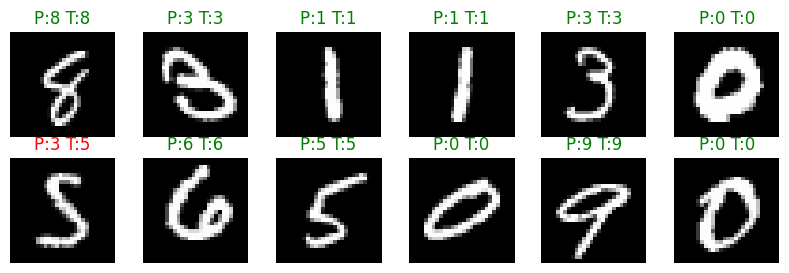

In [125]:
import random

test_batches = list(test_loader)
test_images, test_labels = random.choice(test_batches)
test_images = test_images.to(device)

# use parallel predict for a single batch
try:
    zs = scripted_wrapper.parallel_predict(test_images, 4)
except Exception:
    zs = model.predict(test_images)

preds = zs[-1].argmax(dim=1)

fig = plt.figure(figsize=(10, 3))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    img = test_images[i].cpu().squeeze() * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    color = 'green' if preds[i]==test_labels[i] else 'red'
    ax.set_title(f"P:{preds[i].item()} T:{test_labels[i].item()}", color=color)
    ax.axis('off')
plt.show()

### Training and Validation Curves
- Plot loss and accuracy curves for training and validation sets.
- Visualize model learning progress over epochs.


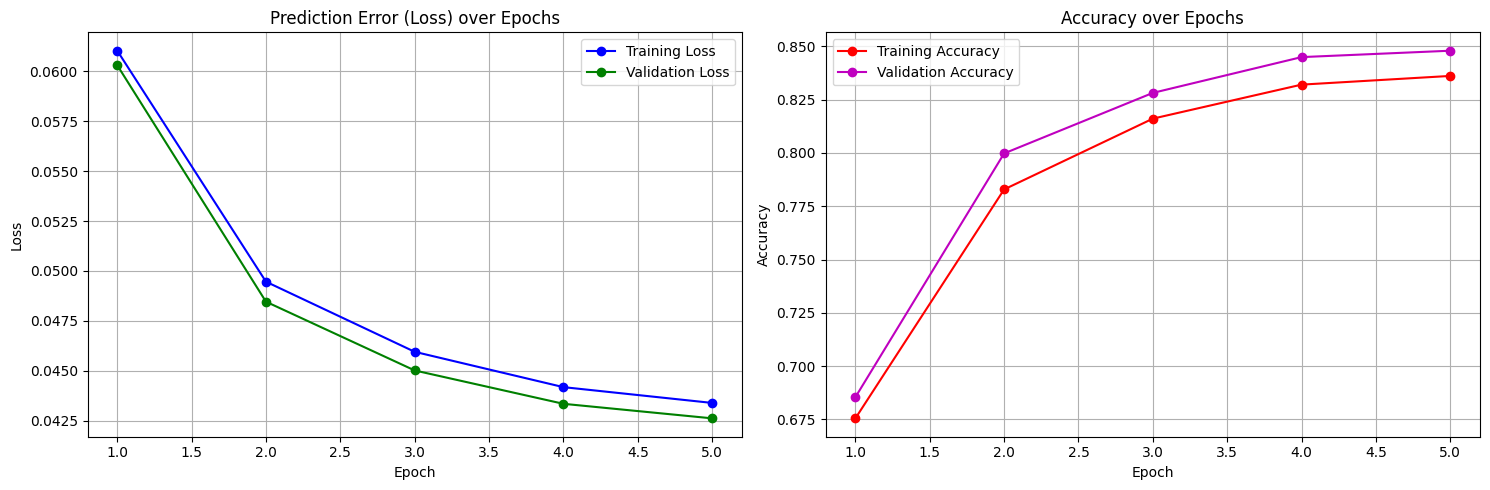

In [126]:
plt.figure(figsize=(15, 5))

# Prediction Error (Loss)
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'g-o', label='Validation Loss')
plt.title('Prediction Error (Loss) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'r-o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'm-o', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix and Per-Class Accuracy
- Compute and display the confusion matrix for test predictions.
- Plot per-class accuracy and print detailed results.


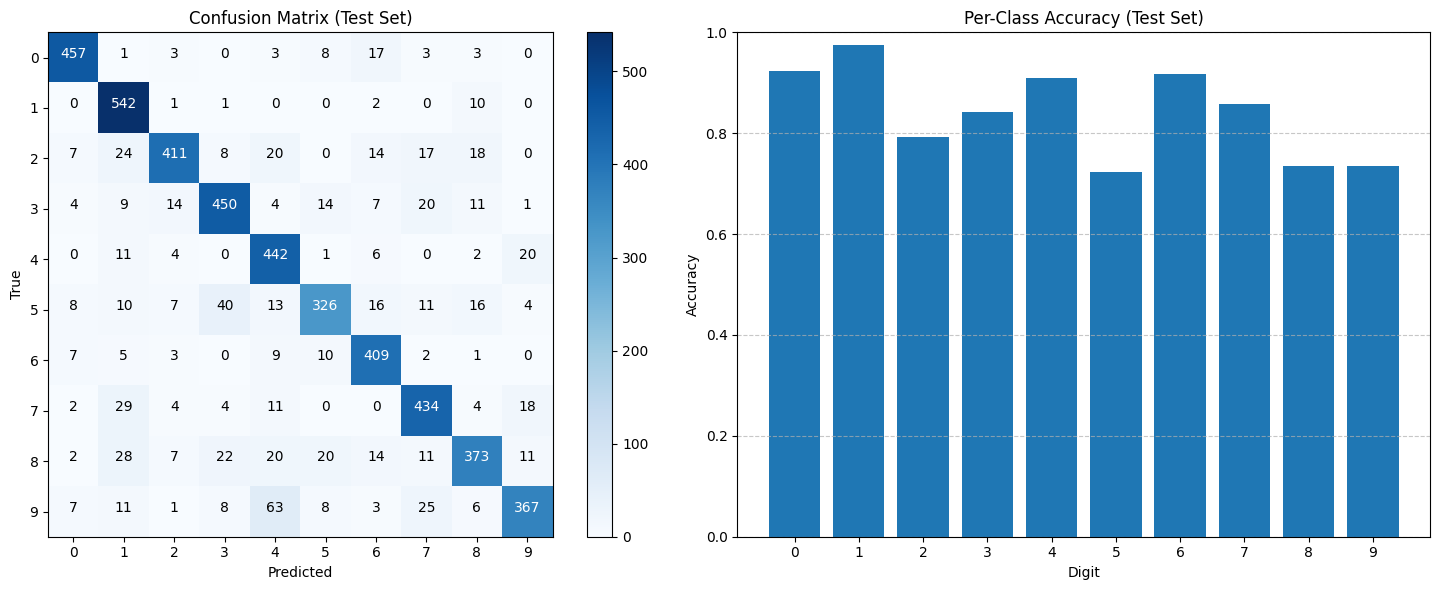


Per-class accuracies on the final test set:
Digit 0: 0.9232
Digit 1: 0.9748
Digit 2: 0.7919
Digit 3: 0.8427
Digit 4: 0.9095
Digit 5: 0.7228
Digit 6: 0.9170
Digit 7: 0.8577
Digit 8: 0.7343
Digit 9: 0.7355


In [127]:
plt.figure(figsize=(15, 6))

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        try:
            zs = scripted_wrapper.parallel_predict(images, 4)
        except Exception:
            zs = model.predict(images)
        preds = zs[-1].argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# calculate the confusion matrix
conf_matrix = np.zeros((10, 10))
for t, p in zip(y_true, y_pred):
    conf_matrix[t, p] += 1

# confusion Matrix
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.yticks(np.arange(10), [str(i) for i in range(10)])

thresh = conf_matrix.max() / 2.
for i in range(10):
    for j in range(10):
        plt.text(j, i, int(conf_matrix[i, j]),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

# Per-Class Accuracy
plt.subplot(1, 2, 2)
per_class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.bar(range(10), per_class_acc)
plt.title('Per-Class Accuracy (Test Set)')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nPer-class accuracies on the final test set:")
for digit, acc in enumerate(per_class_acc):
    print(f"Digit {digit}: {acc:.4f}")


